# model

Please refer to README file for project overview.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
processed_images_dir = "processed_images_224x224/"

In [2]:

import matplotlib.image as mpimg
from scipy import misc
import matplotlib.pyplot as plt
import cv2

In [3]:
import DataHelper
#print(DataHelper.__doc__)
from DataHelper import test_read_csv, read_csv
#print(read_csv.__doc__)
#test_read_csv()
# fetch actual log of driving data
headers, data = read_csv(data_dir + "driving_log.csv")

Using TensorFlow backend.


imported rows 8037


# Labels (steering value classes)

- Please review notebook "preprocessing", section: "Steering value distribution".
- Training labels have values ranging from -1 to +1.
- When you steer with **keyboard** the STEPS are rather corse, so I think I can get away with **discrete steering angles, i.e. classes**.
- I will start training with 21 equally spread classes, if needed I will increase to 41.
- I want to make sure that my classes include **0.0 (zero)** as it is most common value.

steering_classes [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
Number of classes 21


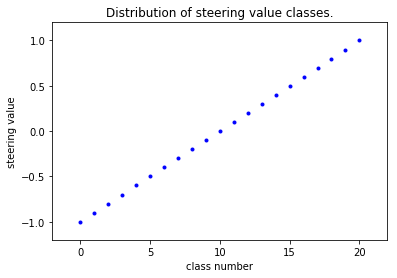

In [4]:
import numpy as np
from numpy import ndarray
number_of_classes = 21
steering_classes = np.linspace(-1, 1, num=number_of_classes, endpoint=True) 
steering_classes = np.sort(steering_classes)
print("steering_classes", steering_classes)
number_of_classes = steering_classes.shape[0]
print("Number of classes", number_of_classes)

import matplotlib.pyplot as plt
plt.plot(steering_classes, 'b.')
plt.margins(0.1)
plt.title("Distribution of steering value classes.")
plt.xlabel("class number")
plt.ylabel('steering value')
plt.show()

# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random, get_image_center_values
image_center_values = get_image_center_values(data)

training, testing, validation = \
split_random(data, percent_train=5, percent_test=15) 

print("training",training.shape)
print("testing",testing.shape)
print("validation",validation.shape)

percent_validation 80
training (402, 7)
testing (1206, 7)
validation (6428, 7)


# Extract training features (images)

In [6]:
from DataHelper import get_image_center_values 
image_names = get_image_center_values(training)
print(image_names.shape)
print(image_names[1])

(402,)
IMG/center_2016_12_01_13_34_15_045.jpg


## Create a list of image paths pointing to 64px version

In [7]:
image_paths = []
for image_name in image_names:
    image_paths.extend([data_dir + processed_images_dir + image_name])
print(image_paths[1]) 

../../../DATA/behavioral_cloning_data/processed_images_224x224/IMG/center_2016_12_01_13_34_15_045.jpg


matrix shape (402, 224, 224, 3)


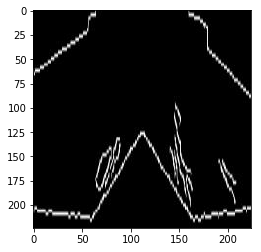

In [8]:
from DataHelper import read_image
training_features = np.array([ read_image(path) for path in image_paths] )

print ("matrix shape", training_features.shape)
plt.imshow(training_features[2], cmap='gray')
plt.show()
#print (training_features[2])

In [9]:
from DataHelper import normalize_grayscale

training_features_normalized = normalize_grayscale(training_features)

# Extract training labels (steering value classes) 

In [10]:
from DataHelper import get_steering_values, find_nearest
raw_labels = get_steering_values(training)
print(raw_labels.shape)
print(raw_labels[0:5])

training_labels = np.array([], dtype=np.float64)

for raw_label in raw_labels: # raw_labels[:5]
    #print("raw_label", raw_label)
    label = find_nearest(steering_classes, raw_label)
    #print("normalized label", label)
    
    # Classification labels should be strings:
    training_labels = np.append(training_labels, [str(label)])
        
print(training_labels)

(402,)
[ 0.          0.          0.          0.2722676  -0.00279104]
['0.0' '0.0' '0.0' '0.3' '0.0' '0.0' '0.0' '-0.2' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.5' '0.0' '0.0' '0.3' '0.0' '0.0' '0.0' '-0.3' '0.0' '0.0' '0.0'
 '0.0' '0.2' '0.0' '0.0' '0.0' '0.0' '0.2' '0.2' '-0.2' '0.0' '0.1' '0.0'
 '0.1' '0.0' '0.0' '0.2' '-0.1' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '-0.1' '0.0' '0.1' '0.0' '0.0' '0.0' '-0.2' '0.3' '0.0' '0.0' '0.0'
 '0.0' '0.3' '0.0' '-0.3' '0.0' '-0.1' '0.0' '0.0' '0.0' '0.1' '0.0' '0.2'
 '0.2' '0.1' '0.0' '0.0' '0.1' '0.0' '0.0' '0.1' '0.3' '-0.1' '-0.1' '0.0'
 '-0.1' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.2' '0.0' '-0.2' '0.0' '0.0'
 '-0.2' '0.0' '0.0' '0.0' '-0.2' '0.0' '0.0' '0.1' '-0.3' '0.0' '-0.3'
 '0.0' '-0.1' '0.0' '0.3' '-0.2' '-0.1' '0.0' '0.0' '0.0' '0.0' '-0.1'
 '0.0' '-0.1' '0.0' '-0.1' '0.0' '0.0' '0.0' '-0.1' '0.0' '-0.1' '0.1'
 '0.0' '-0.1' '0.0' '0.2' '-0.1' '-0.1' '0.1' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.2' '0.0' '0.0' '0.0' '-0.1' '0.0' '0.0' '0

## One hot

In [85]:
def sort_unique_floats(array_x):
    # assure that the array is numpy and numerical
    #array_x = array_x.astype(np.float)
    
    # get unique values, a.k.a. set of values
    labels_set = set(array_x)
    #print("labels_set\n", labels_set)
    
    # set is not sorted, so convert it to a numpy array
    unique_labels = np.array(list(labels_set))
    #print("unique_labels\n", unique_labels.shape, unique_labels)
    
    sorted_unique_labels = np.sort(unique_labels)
    #print("sorted_unique_labels\n", sorted_unique_labels.shape, sorted_unique_labels)
    return sorted_unique_labels
    
# TEST   
sorted_unique_labels = sort_unique_floats(training_labels)
print("sorted_unique_labels X\n",  sorted_unique_labels)

sorted_unique_labels X
 ['-0.1' '-0.2' '-0.3' '-0.4' '-0.5' '0.0' '0.1' '0.2' '0.3' '0.4' '0.5']


In [99]:
def encode_one_hot(all_possible_classes, training_labels):
    """
    Creates one hot encoded vector from a list {1D vector (None,)} containing training labels.
    - find all unique labels
    - count all unique labels
    - create a zero filed array, size equal to count of all unique labels
    - order the unique values (small to large)
    - create empty output matrix
    - for each sample's label create zero vector and set one in position of that label 
    """
    all_possible_classes = sort_unique_floats(all_possible_classes)
    print("all_possible_classes", all_possible_classes)
    
    class_count = len(all_possible_classes)
    print("class_count", class_count)
    
    smaple_count = len(training_labels)
    print("smaple_count", smaple_count)
    
    blank_zero = np.zeros(shape=(smaple_count,smaple_count))
    print("blank_zero", blank_zero.shape)
    print("blank_zero", blank_zero[3].shape)
    
encode_one_hot(steering_classes, training_labels)

all_possible_classes [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
class_count 21
smaple_count 402
blank_zero (402, 402)
blank_zero (402,)


In [69]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_one_hot = enc.fit_transform(training_labels,y=402).toarray()
print("y_one_hot", y_one_hot.shape)
print(enc.n_values_)

y_one_hot (1, 402)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/ukilucas/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_labels)
X_train_counts.shape

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [13]:
import sklearn
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import one_hot

#label_binarizer = LabelBinarizer()
#y_one_hot = one_hot(training_labels, 21)
#y_one_hot = one_hot_encoding(training_labels)
#y_one_hot = label_binarizer.fit_transform(training_labels)
#print("y_one_hot", y_one_hot.shape)

# Extract 

# Keras (with TensorFlow)

https://keras.io/layers/convolutional/

In [14]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda

from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates

from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D
print("training_features_normalized", training_features_normalized.shape)
print("y_one_hot", y_one_hot.shape)

training_features_normalized (402, 224, 224, 3)
y_one_hot (1, 402)


### See Model_Keras_VGG_16.py

This file (in the same directory) contains MODEL definiteion for VGG.16.

In [15]:
#from Model_Keras_VGG_16 import build_model # model = build_model('vgg16_weights.h5')
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16

In [16]:
def show_layers(model):
    for i in range(len(model.layers)):
        layer = model.layers[i]
        print(i, ") ",layer.name, "\t\t is trainable: ", layer.trainable)
        #layer.trainable = False

In [17]:
#model = build_model()
model_VGG16 = VGG16(weights=None, include_top=True)
model_VGG16.summary()
show_layers(model_VGG16)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [18]:
from keras.models import Model
#x = Dense(8, activation='softmax', name='predictions2')(model)
x = Dense(21, activation='softmax', name='predictions')(model_VGG16.layers[-2].output)
#Then create the corresponding model 
model = Model(input=model_VGG16.input, output=x)
model.summary()

#print(model.get_layer("predictions").name)

#Create your own model 
#my_model = Model(input=input, output=x)

#model.summary()
#show_layers(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [19]:
# Before training a model, you need to configure the learning process, which is done via the compile method.
optimizer='sgd' # | 'rmsprop'
loss_function='mean_squared_error' # | 'binary_crossentropy' | 'mse'
metrics_array=['accuracy', mean_pred, false_rates]

model.compile(optimizer, loss_function, metrics_array)

print("features", training_features_normalized.shape)
print("labels", training_labels.shape)
print("y_one_hot", y_one_hot.shape)
print("y_one_hot", y_one_hot)

features (402, 224, 224, 3)
labels (402,)
y_one_hot (1, 402)
y_one_hot [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.

In [20]:
#history = model.fit(training_features_normalized, training_labels, nb_epoch=3, verbose=1, validation_split=0.2)
history = model.fit(training_features_normalized, y_one_hot, nb_epoch=3, validation_split=0.2)

#Epoch 20/20 loss: 0.0518 - acc: 0.60 - val_loss: 0.05 - val_acc: 0.59

ValueError: Error when checking model target: expected predictions to have shape (None, 21) but got array with shape (1, 402)

In [ ]:
#    im = cv2.resize(cv2.imread('cat.jpg'), (224, 224)).astype(np.float32)
#    im[:,:,0] -= 103.939
#    im[:,:,1] -= 116.779
#    im[:,:,2] -= 123.68
#    im = im.transpose((2,0,1))
#    im = np.expand_dims(im, axis=0)
#
#    # Test pretrained model
#    model = VGG_16('vgg16_weights.h5')
#   sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#    model.compile(optimizer=sgd, loss='categorical_crossentropy')
#    out = model.predict(im)
#    print np.argmax(out)